/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


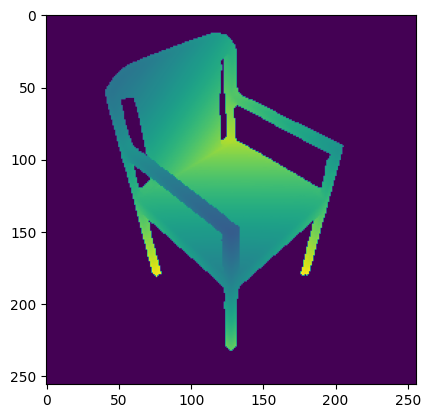

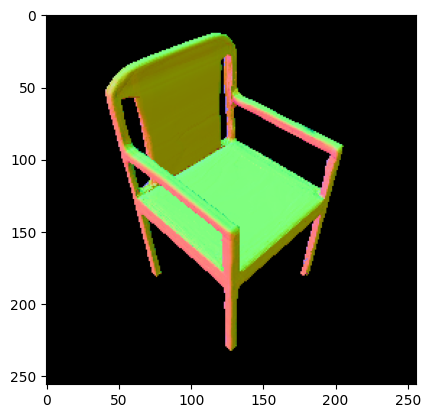

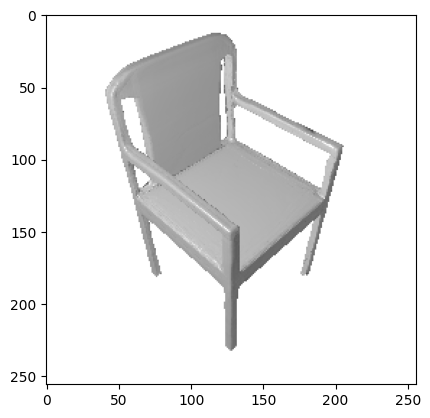

In [1]:
from lib.rendering.utils import visualize_depth, visualize_image, visualize_normals
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
)

ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SignedDistanceFunction(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
sphere_tracer = SphereTracer(max_steps=500, warm_step_scale=1)
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

depth, mask = scene.render_depth() 
visualize_depth(scene.to_image(depth, mask))

normals, mask = scene.render_normals()
visualize_normals(scene.to_image(normals, mask))

image, mask = scene.render_image()
visualize_image(scene.to_image(image, mask, default=1))

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  0%|          | 0/100 [00:00<?, ?it/s]

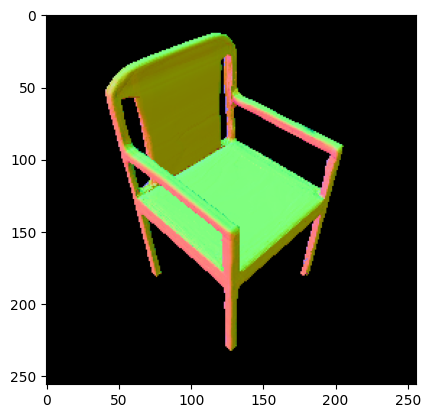

 10%|█         | 10/100 [00:50<03:05,  2.06s/it]

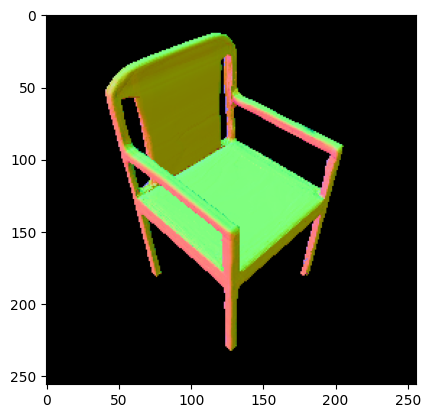

 15%|█▌        | 15/100 [00:59<05:37,  3.97s/it]


KeyboardInterrupt: 

In [2]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.nn.functional import normalize
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"

sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
# sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda")
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)

optimizer = Adam(sdf.model.parameters(), lr=1e-04)

for steps in tqdm(range(100)):
    points, mask, _ = scene.sphere_tracing()
    sdf.lat_vec.requires_grad = True
    points.requires_grad = True
    sd = sdf.predict(points, mask)
    grad, = torch.autograd.grad(
        outputs=sd, 
        inputs=points, 
        grad_outputs=torch.ones_like(sd), 
        retain_graph=True,
    )
    grad.requires_grad = True
    target_normals = normalize(grad)
    
    # loss = sd.sum()
    # loss.backward(retain_graph=True)
    # target_normals = normalize(points.grad)  # type: ignore
    
    loss = torch.norm(target_normals[mask] - normals[mask])
    loss.backward()

    if steps % 10 == 0: 
        # print(steps, loss)
        visualize_normals(scene._to_image(target_normals, mask))

    optimizer.step()
    optimizer.zero_grad()


In [14]:
points

tensor([[ 0.1733,  0.7292,  1.4796],
        [ 0.1802,  0.7248,  1.4686],
        [ 0.1870,  0.7204,  1.4577],
        ...,
        [-0.0600, -0.4592, -1.2903],
        [-0.0560, -0.4641, -1.2940],
        [-0.0521, -0.4689, -1.2977]], device='cuda:0', requires_grad=True)

In [13]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
sketch_path = "/home/borth/sketch2shape/data/siamese_chair_large/96d9944f46bd330979414e04132a8bef/sketches/00021.jpg"

# siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
# sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda")
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)

optimizer = Adam(sdf.model.parameters(), lr=1e-04)
normals.requires_grad = True

for steps in tqdm(range(100)):
    # image_emb = siamese.decoder(image[None])
    # normalized_image_emb = torch.nn.functional.normalize(image_emb)
    # loss = (sketch_emb @ image_emb.T).sum()
    target_normals, mask = scene.render_normals()
    
    loss = torch.norm(target_normals[mask] - normals[mask])
    loss.backward(retain_graph=True)

    if steps % 10 == 0: 
        print(steps, loss)
        visualize_normals(target_normals) 

    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

torch.Size([196608, 1])

In [58]:
from lib.utils import load_config
from lightning import Trainer
from lib.eval.tester import SiameseTester
import hydra

cfg = load_config("eval_siamese", overrides=["+experiment=eval"])
tester = SiameseTester(model=siamese.decoder)
datamodule = hydra.utils.instantiate(cfg.data, train=False)
datamodule.setup("all")
trainer = Trainer(
    accelerator="gpu",
    max_epochs=1,
    enable_checkpointing=False,
)
trainer.validate(
    tester,
    dataloaders=[
        datamodule.train_dataloader(),
        datamodule.val_dataloader(),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/borth/sketch2shape/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{}, {}]